In [1]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import HTML
HTML('<style>.container { width:97% !important; }</style><style>.output_png {display: table-cell;text-align: center;vertical-align: middle;}</style>')

# MODEL 1
## Kernel: Spektral (200 epochs, 15 patience) + NO ADDED INFO
## PCA (from 128 to 2)

In [11]:
import load_data as ld
import embedder_generator as gen
import embedder
import utilities as ut

from sklearn.model_selection import train_test_split

from sklearn.decomposition import TruncatedSVD
import umap

import keras.backend as K
from my_callbacks import MyCallback_sinusoidal
from sklearn.preprocessing import Normalizer

In [12]:
#name = "generate_graphs/125_pos_neg_BALANCED(2038)" #Leukemia
#name = "generate_graphs/489028_pos_neg_BALANCED(2864)" #Cancer
#name = "generate_graphs/1111_pos_neg_BALANCED" # AIDS
#name = "generate_graphs/2222_pos_neg_(BALANCED)" # PROTEINS
name = "generate_graphs/3333_pos_neg_(BALANCED)" # DHFR

In [13]:
# load data 
#graphs,labels = ld.load_data("MUTAG")
graphs,labels = ld.load_data_pubchem(name)


# NO vectorizer
max_n_nodes, n_attributes = ut.find_shapes(graphs)
print("n_ attributes: "+str(n_attributes))

#split train test
graphs_train, graphs_test, labels_train, labels_test = train_test_split(graphs, labels, test_size=0.2, random_state=42)

n_ attributes: 5


In [23]:
# build models
spk_cla,spk_emb = gen.gen_SpektralGNN_emb(n_classes=2,
                                            max_n_nodes = max_n_nodes,
                                            n_attributes = n_attributes,
                                            n_components= 128)

emb_spk = embedder.Kernel_GNN(classificator = spk_cla,
                              embedder = spk_emb,
                              batch_size = 32,
                              validation_split = 0.2,
                              epochs = 200,
                              patience = 15,
                              callbacks=None,
                              verbose=0)

# fit spk
emb_spk.fit(graphs_train,labels_train)

# transfrom train and test to n_componentes = 128
X_train = emb_spk.transform(graphs_train)
X_test = emb_spk.transform(graphs_test)

Stopped epoch:  61


In [24]:
ut.evaluate_emb_train_test(X_test,labels_test,X_train,labels_train)

DIM: 128            TEST    TRAIN
----------------  ------  -------
K.N.N.  accuracy   0.838    0.862


# FROM 128 TO 2

DIM: 2              TEST    TRAIN
----------------  ------  -------
K.N.N.  accuracy   0.615    0.662


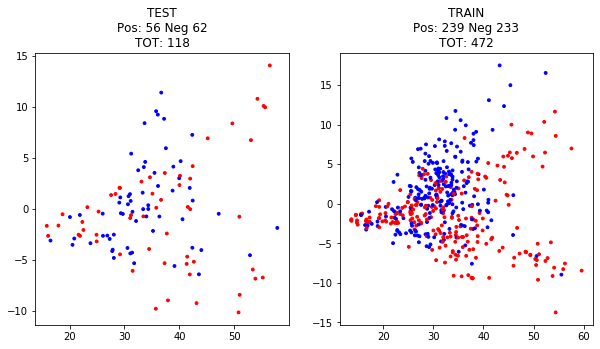

In [26]:
pca = TruncatedSVD(n_components=2)

emb_pca = embedder.Transformer(pca)

emb_pca.fit(X_train,labels_train)

X2_train = emb_pca.transform(X_train)
X2_test = emb_pca.transform(X_test)

ut.evaluate_emb_train_test(X2_test,labels_test,X2_train,labels_train)
plot2d_tmp(X2_test,labels_test,X2_train,labels_train)

# Repeate the process 5 times
### Return (acc train/test dims: 128,2 - 5 embeddings 2d - 5 labels)

In [9]:
#name = "generate_graphs/125_pos_neg_BALANCED(2038)" #Leukemia
name = "generate_graphs/489028_pos_neg_BALANCED(2864)" #Cancer
#name = "generate_graphs/1111_pos_neg_BALANCED" # AIDS
#name = "generate_graphs/2222_pos_neg_(BALANCED)" # PROTEINS
#name = "generate_graphs/3333_pos_neg_(BALANCED)" # DHFR
n_bits = 8 #8
n_times = 5 #5

res_dhfr = execute(name,n_bits,n_times,prot=False)

n_ attributes: 1
Stopped epoch:  138
DIM: 128            TEST    TRAIN
----------------  ------  -------
K.N.N.  accuracy   0.495    0.521
DIM: 2              TEST    TRAIN
----------------  ------  -------
K.N.N.  accuracy   0.495    0.539
Stopped epoch:  111
DIM: 128            TEST    TRAIN
----------------  ------  -------
K.N.N.  accuracy   0.472    0.518
DIM: 2              TEST    TRAIN
----------------  ------  -------
K.N.N.  accuracy   0.475    0.524
Stopped epoch:  129
DIM: 128            TEST    TRAIN
----------------  ------  -------
K.N.N.  accuracy   0.521    0.506
DIM: 2              TEST    TRAIN
----------------  ------  -------
K.N.N.  accuracy   0.517    0.524
Stopped epoch:  134
DIM: 128            TEST    TRAIN
----------------  ------  -------
K.N.N.  accuracy    0.52    0.513
DIM: 2              TEST    TRAIN
----------------  ------  -------
K.N.N.  accuracy   0.512    0.502
Stopped epoch:  143
DIM: 128            TEST    TRAIN
----------------  ------  -------

# Save results

In [10]:
np.save("Model0_spk_res_canc",res_dhfr, allow_pickle=True)

# Used methods

In [3]:
import networkx as nx
def remove_big_graphs(graphs_in,labels_in):
    grpahs_in = np.array(graphs_in)
    print("sto eliminado i grafi grandi")
    graphs = []
    labels = []
    for j in range(len(graphs_in)):
        n_nodes = graphs_in[j].number_of_nodes() 
        if (n_nodes < 150):
            graphs.append(graphs_in[j])
            labels.append(labels_in[j])
    print(len(graphs))
    graphs = np.array(graphs)
    labels = np.array(labels)
    return(graphs,labels)

In [4]:
from sklearn.model_selection import StratifiedKFold
def execute(name,n_bits=8,n_times=5,prot=False):
    
    acc_128_test = []
    acc_128_train = []
    acc_2_test = []
    acc_2_train = []
    X2_test = []
    X2_train = []
    lab_test = []
    lab_train = []
    
    
    kFold = StratifiedKFold(n_splits=5)
    
    #print("TMP MUTAG")
    #graphs,labels = ld.load_data("MUTAG")
    graphs,labels = ld.load_data_pubchem(name)
    if (prot == True):
        print("removing_big_graphs")
        remove_big_graphs(graphs,labels)
        
    
    max_n_nodes, n_attributes = ut.find_shapes(graphs)
    print("n_ attributes: "+str(n_attributes))
    
    graphs = np.array(graphs)
    #split train test
    count = 0
    for train, test in kFold.split(graphs, labels):
        if (count == n_times):
            break
            
        graphs_train = graphs[train]
        graphs_test = graphs[test]
        labels_train = labels[train]
        labels_test = labels[test]
        
        acc_128_te,acc_128_tr,acc_2_te,acc_2_tr,X2_te,X2_tr = run(graphs_train, graphs_test, labels_train, labels_test,max_n_nodes, n_attributes)
        
        acc_128_test.append(acc_128_te)
        acc_128_train.append(acc_128_tr)
        acc_2_test.append(acc_2_te)
        acc_2_train.append(acc_2_tr)
        X2_test.append(X2_te)
        X2_train.append(X2_tr)
        lab_test.append(labels_test)
        lab_train.append(labels_train)
        
        count = count + 1
        
    return([acc_128_test,acc_128_train,acc_2_test,acc_2_train,X2_test,X2_train,lab_test,lab_train])

In [5]:
def run(graphs_train, graphs_test, labels_train, labels_test,max_n_nodes, n_attributes):
    # build models
    spk_cla,spk_emb = gen.gen_SpektralGNN_emb(n_classes=2,
                                                max_n_nodes = max_n_nodes,
                                                n_attributes = n_attributes,
                                                n_components= 128)

    emb_spk = embedder.Kernel_GNN(classificator = spk_cla,
                                  embedder = spk_emb,
                                  batch_size = 32,
                                  validation_split = 0.2,
                                  epochs = 200,
                                  patience = 15,
                                  callbacks=None,
                                  verbose=0)

    # fit spk
    emb_spk.fit(graphs_train,labels_train)

    # transfrom train and test to n_componentes = 128
    X_train = emb_spk.transform(graphs_train)
    X_test = emb_spk.transform(graphs_test)
    ut.evaluate_emb_train_test(X_test,labels_test,X_train,labels_train)
    acc_128_test, acc_128_train = ut.evaluate_emb_train_test(X_test,labels_test,X_train,labels_train,return_value=True)

    # mod 2
    pca = TruncatedSVD(n_components=2)
    emb_pca = embedder.Transformer(pca)
    emb_pca.fit(X_train,labels_train)
    X2_train = emb_pca.transform(X_train)
    X2_test = emb_pca.transform(X_test)
    ut.evaluate_emb_train_test(X2_test,labels_test,X2_train,labels_train)
    acc_2_test, acc_2_train = ut.evaluate_emb_train_test(X2_test,labels_test,X2_train,labels_train,return_value=True)

    
    acc_128_test = float(acc_128_test)
    acc_128_train = float(acc_128_train)
    acc_2_test = float(acc_2_test)
    acc_2_train = float(acc_2_train)
    
    return(acc_128_test,acc_128_train,acc_2_test,acc_2_train,list(X2_test),list(X2_train))



In [6]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
def plot2d_tmp(res_test,y_test,res_train,y_train):
    _,[pos_tra,neg_tra] = np.unique(y_train,return_counts=True)
    _,[pos_tes,neg_tes] = np.unique(y_test,return_counts=True)

    colors = ['red','blue']
    plt.figure(figsize=(10,5))
    plt.subplot(121)
    x = res_test[:,0]
    y = res_test[:,1]
    plt.title("TEST\nPos: "+str(pos_tes)+" Neg "+str(neg_tes)+"\nTOT: "+str(len(y_test)))
    plt.scatter(x,y,s=8,c=y_test,cmap=matplotlib.colors.ListedColormap(colors))


    plt.subplot(122)
    x = res_train[:,0]
    y = res_train[:,1]
    plt.title("TRAIN\nPos: "+str(pos_tra)+" Neg "+str(neg_tra)+"\nTOT: "+str(len(y_train)))
    plt.scatter(x,y,s=8,c=y_train,cmap=matplotlib.colors.ListedColormap(colors))

    plt.show()
    
    
    